In [29]:
import pandas as pd
import datetime as dt
import random
import sys
import traceback

from enum import Enum
import pickle
import dill
from matplotlib.lines import Line2D
from textwrap import fill
import matplotlib.pyplot  as plt
import numpy as np


COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
          '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf']
LINEWIDTH_DEFAULT=2

# AP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/AP_Acoustic Response_all_xlsx.xlsx"
AP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/AP_yeti_blue_small-scale.xlsx"
LEAP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/LEAP_Impedance.txt"
KLIPPEL_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/NFS_CEA2034.txt"

In [18]:
class Extended_Enum(Enum):
    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

    @classmethod
    def index(cls, _type):
        return list(cls).index(_type)

class CurveType(Extended_Enum):
    NoType = 'None'
    SPL = 'SPL'
    IMP = 'Impedance'
    PHS = 'Phase'
    THD = 'THD'
    EXC = 'Excursion'
    ALL = 'All'
    

def determineTypeByTestName(test_name):
    if ("Phase" in test_name):
        return CurveType.PHS
    elif ("Impedance" in test_name):
        return CurveType.IMP
    elif ("SPL" in test_name or "CEA" in test_name or 'RMS' in test_name):
        return CurveType.SPL
    elif ("THD" in test_name):
        return CurveType.THD
    else:
        return CurveType.NoType


In [7]:
class Project():
    def __init__(self, name="Untitled"):
        self.info = {
            "Name": name,
            "File Location": sys.path[0],
            'Create Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
            'Last Saved Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
        }
        self.files = []
        self.ui_conf = UI_CONF

    def print(self):
        print("\nProject: =================")
        print("Name: %s \nFile location: %s" %
              (self.info["Name"], self.get_path()))
        for _f in self.files:
            _f.print()
        print("============================\n")

    def append_file(self, file):
        self.files.append(file)

    def delete_files(self, files):
        for _f in files:
            self.files.remove(_f)

    def clear_files(self):
        self.files = []

    def get_path(self):
        return self.info['File Location'] + '/' + self.info['Name'] + '.pkl'

    def dump(self, location=None):
        if not location:
            location = self.get_path()
        # update curveData

        self.print()
        try:
            with open(location, 'wb') as fh:
                self.info["Last Saved Time"] = dt.datetime.today().strftime(
                    "%Y/%m/%d %H:%M:%S")
                pickle.dump(self, fh)
        except:
            print(dill.detect.baditems(self))

    @classmethod
    def load_project(cls, location=None):
        print("unpickled project:")
        print("location: ", location)
        if location == "None":
            return Project()
        else:
            try:
                fh = open(location, 'rb')
                # with open(f"%s.pkl" % (location), 'rb') as fh:
                unpickled_project = pickle.load(fh)
                if location is not unpickled_project.info["File Location"]:
                    print(
                        "WARNING: File location not the same --> change project info.")
                    unpickled_project.info["File Location"] = location
                unpickled_project.print()
                print("____________finish obj_data.Project.load_project()")
                fh.close()
                return unpickled_project
            except Exception as e:
                return Project()

    def update_ui_conf(self):
        self.ui_conf["MyCanvas"]["mode"] = self.wg_canvas.mode
        for mode, canvas_set in self.wg_canvas.status.items():
            self.ui_conf["MyCanvas"]["status"][mode] = [
                _c.id for _c in canvas_set]
        for _c in self.wg_canvas.canvasPool:
            self.ui_conf["MyCanvas"]["canvasPool"][str(_c.id)]["types"] = [
                _t.value for _t in _c.ax_types]
            self.ui_conf["MyCanvas"]["canvasPool"][str(
                _c.id)]["parameter"] = _c.parameter
        # with open("ui_conf.json", "w") as fj:
        #     json.dump(self.ui_conf, fj)
        # print("update_ui_conf", self.ui_conf)

    def get_files(self, filenames):
        files_to_return = []
        for _f in self.files:
            if _f.info["Name"] in filenames and _f not in files_to_return:
                files_to_return.append(_f)
        return files_to_return

In [8]:
class FileData():
    def __init__(self, name=None, source=None, file_path=None, import_time=None):
        self.info = {
            "Name": name,
            "Source": source,
            "File Path": file_path,
            'Import Time': import_time,
            'Last Modified Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
        }
        self.sequence = {}

    def print(self):
        print("------------")
        print("\tName: %s \n\tSource: %s \n\tfile_path: %s" %
              (self.info["Name"], self.info["Source"], self.info["File Path"]))
        print("\tImport time: ", self.get_import_time())
        print("\tSequence:")
        for _k, _v in self.sequence.items():
            print("\t  Key: ", _k)
            print("\t  Curves:")
            for _c in _v:
                print(f"\t\t%s, %s, %s" % (_c.type.value, _c.label, _c.note))
        print("-----------------------------")

    def update_sequence(self, dataSequence):
        for test, curveData in dataSequence:
            self.sequence[test] = curveData

    def get_import_time(self):
        return self.info["Import Time"].strftime("%Y/%m/%d %H:%M:%S")

In [9]:
class CurveData:
    def __init__(self, label=None, note=None, xdata=None, ydata=None, _type=None, units=[], color=COLORS[0]):
        self.label = label
        self.note = note
        self.xdata = xdata
        self.ydata = ydata
        self.type = _type
        self.shifted = 0
        self.units = units
        self.line = None
        self.line_props = {
            "visible": False,
            "color": color,
            "linewidth": LINEWIDTH_DEFAULT,
        }

  # Class Function
    def __getstate__(self):
        state = self.__dict__.copy()
        # Don't pickle baz

        del state["line"]
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        # Add baz back since it doesn't exist in the pickle
        self.line = None

    def print(self):
        print(f"%s, %s, %s" % (self.type.value, self.label, self.note))
  # Get and Set Function

    def get_legend(self, legend_wrap):

        return fill(self.label, legend_wrap)

    def get_ymax(self):
        print(self.ydata.max())

    def get_dict(self):
        dictToJSON = {
            'Data Type': self.type.value,
            'xData': self.xdata.to_numpy().tolist(),
            'yData': self.ydata.to_numpy().tolist(),
            'Label': self.label,
            'Note': self.note,
            'line_props': self.line_props
        }
        return dictToJSON

    def create_line2D(self, ax, legend_wrap):
        self.label = self.label.replace('\n', '')
        self.line, = ax.plot(self.xdata, self.ydata,
                             label=self.get_legend(legend_wrap), color=self.line_props["color"], picker=True)
  # Curve Unary Function

    def shift(self, offset):
        xdata, ydata = self.line.get_data()
        new_ydata = [d+(offset-self.shifted) for d in ydata]
        self.line.set_data(xdata, new_ydata)
        self.shifted += (offset-self.shifted)

    def align(self, targetDB, freq):
        xdata, ydata = self.line.get_data()
        (index, freq) = min(enumerate(xdata), key=lambda x: abs(x[1]-freq))
        offset = targetDB - ydata[index]
        self.shift(offset)

  # Save and Sync
    def sync_with_line(self):
        if self.line:
            self.label = self.line.get_label().replace('\n', '')
            self.line_props["color"] = self.line.get_color()
            self.line_props["linewidth"] = self.line.get_linewidth()
        else:
            pass

    def dump(self):
        self.print()
        try:
            with open(f"%s.pkl" % ("curvedata"), 'wb') as fh:
                pickle.dump(self, fh)
        except:
            print(dill.detect.baditems(self))

In [10]:
def load_AP_fileData(path):
    filename = path[path.rfind('/')+1:path.rfind('.')]

    filedata = None

    if path.endswith('.xlsx'):
        data = pd.read_excel(path, engine="openpyxl", sheet_name=None)
        filedata = FileData(filename, source="AP", file_path=path,
                            import_time=dt.datetime.today())
        curve_idx = 0
        for key in data.keys():
            test_name = data[key].columns[0].strip()
            _type = determineTypeByTestName(test_name)
            note = data[key].columns[1].strip()
            curveDatas = []
            isline = True
            if test_name not in filedata.sequence:
                curve_idx = 0

            for _idx in range(int(len(data[key].columns)/2)):
                label = data[key].iloc[0, _idx*2].strip()
                curve_x = pd.Series(
                    data[key].iloc[3:, _idx*2], name='x', dtype=float)
                curve_y = pd.Series(
                    data[key].iloc[3:, _idx*2+1], name='y', dtype=float)
                units = [data[key].iloc[2, _idx*2],
                         data[key].iloc[2, _idx*2+1]]
                if (curve_x.dtype != float or curve_y.dtype != float):
                    isline = False
                    continue

                curveData_new = CurveData(
                    label=label, note=note, xdata=curve_x, ydata=curve_y, _type=_type, color=COLORS[curve_idx % 10], units=units)
                curveDatas.append(curveData_new)
                curve_idx += 1

            if (not isline):
                continue
            if test_name in filedata.sequence:
                filedata.sequence[test_name].extend(curveDatas)
            else:
                filedata.sequence[test_name] = curveDatas
    else:
        pass
    return filedata

In [11]:
def load_KLIPPEL_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8') as file:
            filename = path[path.rfind('/')+1:path.rfind('.')]
            filedata = FileData(filename, source="KLIPPEL",
                                file_path=path, import_time=dt.datetime.today())

            headers = file.readlines()[:3]
            if headers[0][0] == '%':
                raise Exception(
                    "file header start with %, it is a comsole file")
            test_name = headers[0].strip().strip('"')
            labels = headers[1].split('\t\t')
            labels = [c.replace('"', '').strip() for c in labels]

            unit_arr = headers[2].split('\t')
            unit_arr = [c.replace('"', '').strip() for c in unit_arr]

            data = pd.read_table(path,  skiprows=2)
            data = data.dropna()
            curveDatas = []
            note = ""

            # freq = data.iloc[:, 0]
            # freq = [float(f.replace(',', '').strip()) for f in freq]
            # freq = pd.Series(freq, name='x', dtype=float)

            _type = determineTypeByTestName(test_name)

            for i in range(int(len(data.columns)/2)):
                val = pd.Series(data.iloc[:, i*2+1], name='y', dtype=float)
                freq = data.iloc[:, i*2]
                freq = [float(f.replace(',', '').strip()) for f in freq]
                freq = pd.Series(freq, name='x', dtype=float)
                # 'Frequency [Hz]', 'Sound Pessure Level [dB]  / [2.83V 1m]'
                unit_x = unit_arr[i*2]
                unit_y = unit_arr[i*2+1]
                unit_x = unit_x[unit_x.find('['):unit_x.rfind(']')+1]
                unit_y = unit_y[unit_y.find('['):unit_y.rfind(']')+1]

                units = [unit_x, unit_y]  # ['[Hz]', '[dB]  / [2.83V 1m]']
                filename = unit_arr[i*2][unit_arr[i *
                                                  2].rfind('[')+1:path.rfind(']')]

                curveData_new = CurveData(
                    label=labels[i], note=note, xdata=freq, ydata=val, _type=_type, color=COLORS[i % 10], units=units)

                curveDatas.append(curveData_new)

            if test_name in filedata.sequence:
                pass
            else:
                filedata.sequence[test_name] = []
            filedata.sequence[test_name].extend(curveDatas)
    else:
        pass
    return filedata

In [12]:
def load_LEAP_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8', errors='ignore') as file:
            headers = file.readlines()[:11]
            # LEAP_Impedance
            filename = path[path.rfind('/')+1:path.rfind('.')].strip()
            test_name = filename
            filedata = FileData(filename, source="LEAP",
                                file_path=path, import_time=dt.datetime.today())

            # Impedance_PR: T201100003660
            label = headers[4][headers[4].find('=')+1:].strip()

            units = headers[-1]
            units = units.strip().split(" ")
            units = [x for x in units if x][2:]     # ['Hz', 'Ohm', 'Deg']

            data = pd.read_csv(path,  skiprows=11)
            freq = pd.Series(data.iloc[:, 0], name='x', dtype=float)
            val = pd.Series(data.iloc[:, 1], name='y', dtype=float)
            phase = pd.Series(data.iloc[:, 2], name='y', dtype=float)

            note = ""

            _type = determineTypeByTestName(test_name)

            curveData_val = CurveData(
                label=label, note=note, xdata=freq, ydata=val, _type=_type, color=COLORS[0], units=[units[0], units[1]])

            curveData_phase = CurveData(
                label=label, note=note, xdata=freq, ydata=phase, _type=CurveType.PHS, color=COLORS[1], units=[units[0], units[2]])

            filedata.sequence[test_name] = [curveData_val]
            filedata.sequence["Phase"] = [curveData_phase]
            file.close()
    else:
        pass
    return filedata

In [13]:
def load_COMSOL_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8', errors='ignore') as file:
            headers = file.readlines()[:8]
            filename = path[path.rfind('/')+1:path.rfind('.')]
            test_name = filename
            filedata = FileData(filename, source="COMSOL",
                                file_path=path, import_time=dt.datetime.today())

    #         label = headers[4][headers[4].find('=')+1:]   # Impedance_PR: T201100003660

    #         units = headers[-1]
    #         units = units.strip().split(" ")
    #         units = [x for x in units if x][2:]     # ['Hz', 'Ohm', 'Deg']

            data = pd.read_table(path,  skiprows=7, delim_whitespace=True)
    #         print(data.iloc[:,0])
            freq = pd.Series(data.iloc[:, 0], name='x', dtype=float)
            val = pd.Series(data.iloc[:, 1], name='y', dtype=float)
            # print(freq, val)

            note = ""
            curveData_new = CurveData(
                label=test_name, note=note, xdata=freq, ydata=val, _type=CurveType.SPL, color=COLORS[0])

            filedata.sequence[test_name] = [curveData_new]
            file.close()
    else:
        pass
    return filedata

In [22]:
ap_smallscale = load_AP_fileData(AP_path)

In [24]:
ap_smallscale.print()

------------
	Name: AP_yeti_blue_small-scale 
	Source: AP 
	file_path: C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/AP_yeti_blue_small-scale.xlsx
	Import time:  2021/07/02 10:08:15
	Sequence:
	  Key:  RMS Level -> Smooth
	  Curves:
		SPL, Ch1, default (cardiod)
		SPL, Ch2, default (cardiod)
		SPL, Ch1, Bio-directional
		SPL, Ch2, Bio-directional
		SPL, Ch1, Omni-directional
		SPL, Ch2, Omni-directional
		SPL, Ch1, Stereo
		SPL, Ch2, Stereo
	  Key:  THD Ratio
	  Curves:
		THD, Ch1, default (cardiod)
		THD, Ch2, default (cardiod)
		THD, Ch1, Bio-directional
		THD, Ch2, Bio-directional
		THD, Ch1, Omni-directional
		THD, Ch2, Omni-directional
		THD, Ch1, Stereo
		THD, Ch2, Stereo
	  Key:  THD Level
	  Curves:
		THD, Ch1, default (cardiod)
		THD, Ch2, default (cardiod)
		THD, Ch1, Bio-directional
		THD, Ch2, Bio-directional
		THD, Ch1, Omni-directional
		THD, Ch2, Omni-directional
		THD, Ch1, Stereo
		THD, Ch2, Stereo
-----------------------------


In [34]:
ap_smallscale.sequence["RMS Level -> Smooth"][0].ydata
curveData = ap_smallscale.sequence["RMS Level -> Smooth"][0]

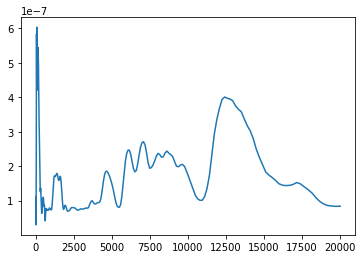

In [35]:
fig, ax = plt.subplots(1, )
ax.plot(curveData.xdata, curveData.ydata)
